This notebook will concentrate on explaining the project, visualizations, insights, and an initial model. An in-depth analysis of the model building process will be contained in subsequent notebooks.

# Table of Contents
1. [Objective](#objective)
2. [Introduction](#intro)
3. [The Dataset](#data)
4. [Import Data and Libraries](#lib)
5. [Exploratory Data Analysis](#eda)
6. [Preprocessing](#preprocessing)
7. [Model](#model)
8. [References](#ref)

# Objective <a id = 'objectve'></a>

The goal of this research project is to predict the age and several other unlabeled variables of a participant, given the 3D fMRI scans, the FNC (functional network connectivity) matrices, and the SBM (source-based morphometry) loading values from resting state fMRI scans. 

Variables to Predict
* `age`
* `domain1_var1`
* `domain1_var2`
* `domain2_var1`
* `domain2_var2`

# Introduction <a id = 'intro'></a>

If we are going to solve this problem, we must first understand what fMRI's are and how they work. Please look at the References section for more information.

Function Magnetic Resonance Imaging (fMRI) is a non-invasive relatively new technology that can map out the interconnectivity of the human brain. 

This imaging technology works by taking advantage of the Blood Oxygenated Level Dependent hemodynamic (BOLD HDR) response of the human brain. The cells in our body work by taking in glucose. The more the cells work, the more glucose it needs. The muscles in our body have a readily available storage located in the muscles themselves. However, our brains do not, and have to compensate this by increasing the blood flow over the neurons during times of increase usage. This is illustrated below by the BOLD response.


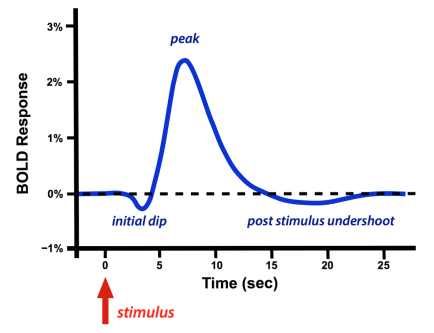


Blood cells contains hemoglobin, which contains iron, a molecular structure that can bind oxygen. When the blood cells become oxygenated, (oxygen bonded to the iron) they are less susceptible to a magnetic field (not magnetic). However, when blood flows over the neurons and is consumed, the blood cells become deoxygenated, becoming much more susceptible to a magnetic field. 

An fMRI is able to detect these regional changes in oxygenation and deoxygenation of hemoglobin, pinpointing areas of increased activity in the brain. 

The brain is mapped out to several components that typically is associated with a specific control, such as processing visual stimuli, the Visual Network. These areas are called the functional networks and are illustrated below.


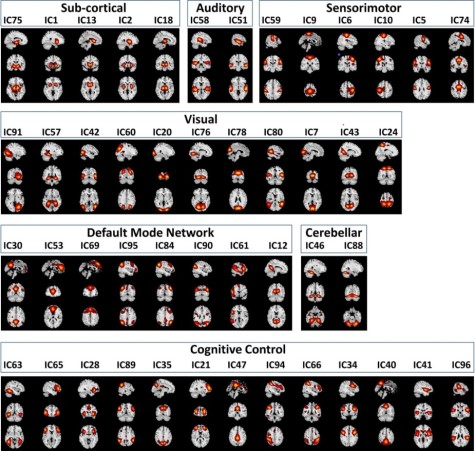

Brain activity is complex, not one area is associated with one function, instead many of these sections are correlated with one another. By understanding these patterns across the brain, we can predict many states and qualities of a person such as psychological disorders, depression, IQ, and even age. This is the scope of our project: to predict the mental qualities of a participant given fMRI results. 

### Introduction to fMRI Video

In [ ]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('dIpoDkv4GHE',width=600, height=400)

# The Dataset <a id = 'data'></a>

The first set of features, located in the file `loading.csv`, are the source-based morphometry (SGM) loading values of each Independent Component (IC) of the brain from the fMRI scans. I am not a neuroscientist, but I believe the BOLD signals are acquired from the fMRI scan and an algorithm separates the data into these independent components, see 'Independent Components' section under References.

The second set of features, located in the file `fnc.csv`, are the correlation values between each predefined functional network of the brain. There are 53 networks, these networks fall into an umbrella group such as the visual network or auditory network. Each of the networks have a correlation value which was obtained from a General Linear Model. 

The third set of features, located in the `fMRI_train` .mat files, are essentially the visualizations of FNC values (before correlation) projected onto a base template of brain. Since the .mat files are derived from the FNC values, we should only use one or the other to avoid collinearity in our models.

### Main Data Files
- `fnc.csv` - static FNC correlation features for both train and test samples
- `loading.csv` - sMRI SBM loadings for both train and test samples
- `train_scores.csv` - age and assessment values for train samples

### Visual fMRI Results
- `fMRI_train` - a folder containing 53 3D spatial maps for each participant in .mat format
- `fMRI_test` - a folder containing 53 3D spatial maps for each participant in .mat format
- `fMRI_mask.nii` - a 3D binary spatial map

### Misc
- `ICN_numbers.txt` - intrinsic connectivity network numbers for each fMRI spatial map; matches FNC names
- `reveal_ID_site2.csv` - a list of subject IDs whose data was collected with a different scanner 

### Submission
- `sample_submission.csv` - a sample submission file in the correct format


The `.mat` files for this competition can be read in python using `h5py`, and the `.nii` file can be read in python using `nilearn`.

# Import Data and Libraries <a id = 'lib'></a>

Before we can look at our dataset, we need to install and import the necessary libraries for this project.

`h5py` and `nilearn` will be needed to read the fMRI scans. We will also use `plotly` for added flexibility in our EDA.

In [ ]:
pip install h5py

In [ ]:
pip install nilearn

In [ ]:
pip install plotly

In [ ]:
pip install joypy

Now import all the essentials and the installed python libraries. 

In [ ]:
#essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as s 

#special libraries
from nilearn import plotting, image 
import nilearn as nl
import nibabel as nb
import h5py
import plotly.graph_objs as go
from IPython.display import Image, display

Lets load the csv files

In [ ]:
df_icn = pd.read_csv('/kaggle/input/trends-assessment-prediction/ICN_numbers.csv')
df_fnc = pd.read_csv('/kaggle/input/trends-assessment-prediction/fnc.csv')
df_loading = pd.read_csv('/kaggle/input/trends-assessment-prediction/loading.csv')
df_reveal = pd.read_csv('/kaggle/input/trends-assessment-prediction/reveal_ID_site2.csv')
df_sample = pd.read_csv('/kaggle/input/trends-assessment-prediction/sample_submission.csv')
df_train = pd.read_csv('/kaggle/input/trends-assessment-prediction/train_scores.csv')

# Exploratory Data Analysis <a id = 'eda'></a>

### fMRI Visuals

The data is of the resting state where the participant is not exposed to any stimuli. They just lay in the fMRI machine and are told to stay still and close their eyes. An fMRI measures obtains slices of the brain in voxels. That is a 3D cube and each cube is assigned a value depending on the BOLD response. There is also a 4th dimension, time. Values change over time, so a sum and average are obtained for each voxel, also each IC of the brain. A correlation between each IC is also obtained.

The ICs are made up of a larger sub groups and are shown in the figure with the groups being:

- DMN - Default Mode Network
- SMN - Sensorimotor Network
- VSN - Visual Network
- CON - Cognitive Network
- ADN - Auditory Network
- CBN - Cerebellar Network
- SCN - Sub-cortical Network


The code below is obtained from 'srs', another Kaggler, from the notebook:

https://www.kaggle.com/srsteinkamp/trends-eda


Every brain is different in terms of size and location of each functional network. Also there are slight variations during each fMRI scan due to head movement, and other variations. So inorder, to standardize the data, an fMRI mask is obtained below. 

In [ ]:
brain_mask = nb.load('/kaggle/input/trends-assessment-prediction/fMRI_mask.nii')
plotting.plot_roi(brain_mask, title='fMRI_mask.nii');

We can also plot each participants fMRI scan grouped by the functional networks.

In [ ]:
test_mat1 = h5py.File('/kaggle/input/trends-assessment-prediction/fMRI_train/10001.mat', mode='r')
test_mat1 = np.array(test_mat1.get('SM_feature'))

## Let's also load a second participant
test_mat2 = h5py.File('/kaggle/input/trends-assessment-prediction/fMRI_train/10002.mat', mode='r')
test_mat2 = np.array(test_mat2.get('SM_feature'))

In [ ]:
#get all fnc unique values ()
fnc_names = pd.Series(df_fnc.columns)
fnc_names = fnc_names.drop(0)
fnc_names = fnc_names.str.split("_", n = 1, expand = True) 
fnc_names[1] = fnc_names[1].str.slice(3,11,1)
fnc_names = fnc_names[0].append(fnc_names[1])
fnc_names = fnc_names.unique()
fnc_names = pd.Series(fnc_names)
fnc_names = fnc_names.sort_values().reset_index(drop = True)

In [ ]:
# Network index:
ntwk_idx = {}
network_names = np.unique([i[:3] for i in fnc_names])
for ii in network_names:
    ntwk_idx[ii] = np.unique([np.int(i.split('(')[-1].split(')')[0]) for i in fnc_names if ii in i])
    
# Look up matrix index
icn_number = pd.read_csv('/kaggle/input/trends-assessment-prediction/ICN_numbers.csv')
icn_idx = {}

for jj in ntwk_idx.keys():
    icn_idx[jj] = np.array(icn_number.index[icn_number.ICN_number.isin(ntwk_idx[jj])])
    
def map_for_plotting(mat, brain_mask):
    # Assuming that we provide a 3D image
    # image.new_img_like creates a nifti by applying informaiton from the soure image (here brain_mask),
    # like the affine to a matrix.
    return image.new_img_like(brain_mask, mat.transpose([2, 1, 0]))
    
# Let's extract the indices for the different average networks
sample_maps1 = {}
sample_maps2 = {}
for ii in icn_idx.keys():
    # indices -1 because matlab
    sample_maps1[ii] = map_for_plotting(test_mat1[icn_idx[ii] -1].mean(0), brain_mask)
    sample_maps2[ii] = map_for_plotting(test_mat2[icn_idx[ii] -1].mean(0), brain_mask)

In [ ]:
fig, axes = plt.subplots(len(sample_maps1), 2, figsize=(20, 10))

for n, ii in enumerate(sample_maps1.keys()):
    # We are plotting glass brains here - a nice way to visualize brain maps
    plotting.plot_glass_brain(sample_maps1[ii], title=ii, axes=axes[n, 0], plot_abs=False)
    plotting.plot_glass_brain(sample_maps2[ii], title=ii, axes=axes[n, 1], plot_abs=False)
axes[0, 0].set_title('Networks for Participant 1');
axes[0, 1].set_title('Networks for Participant 2');

### CSV Files

The following three are the main csv data files. 

- `fnc.csv` as df_fnc
- `loading.csv` as df_loading
- `train_scores.csv` as df_train

The `df_loading.csv` file contains all the values of each part of the brain, Independent Components (ICs) during the fMRI scan. 

In [ ]:
print(df_loading.shape)
df_loading.head(10)

We can see the distribution of the dataset below.

In [ ]:
import joypy

targets = df_loading.columns[1:]

#plot
plt.figure(figsize=(16,10), dpi= 150)
fig, axes = joypy.joyplot(df_loading, column=list(targets), ylim='own', figsize=(14,10))

The `fnc.csv` file shows the correlation between each functional network connection (FNC).

In [ ]:
print(df_fnc.shape)
df_fnc.head(10)

Let's visualize the correlation of an individual participant. We already have the correlation values in the fnc file. We just need to extract the values into a correlation matrix.

In [ ]:
def corr_of_subject(Id):
    
    #get all fnc unique values ()
    x = pd.Series(df_fnc.columns)
    x = x.drop(0)
    x = x.str.split("_", n = 1, expand = True) 
    x[1] = x[1].str.slice(3,11,1)
    x = x[0].append(x[1])
    x = x.unique()
    x = pd.Series(x)
    x = x.sort_values().reset_index(drop = True)
    
    #create empty correlation matrix
    df_corr = pd.DataFrame(np.zeros((53, 53)), columns = x, index = x)
    
    #fill in the correlation matrix
    for i in x: 
        for j in x:
            #define columns and index to pull from df_fnc
            col_from_fnc1 = str(str(i) + '_vs_' + str(j))
            col_from_fnc2 = str(str(j) + '_vs_' + str(i))
            index = df_fnc.index[df_fnc['Id'] == Id]
            
            #assign the correct value
            if col_from_fnc1 in df_fnc.columns:
                df_corr.at[str(i),str(j)] = df_fnc.loc[index, col_from_fnc1]
            elif col_from_fnc2 in df_fnc.columns: 
                df_corr.at[str(i),str(j)] = df_fnc.loc[index, col_from_fnc2]
            else:
                df_corr.at[str(i),str(j)] = 1
    return(df_corr)

In [ ]:
#plot settings
sns.set(font_scale=.75)
plt.figure(figsize = (18,15))

ax = sns.heatmap(corr_of_subject(10001), vmin = -1, cmap = 'RdYlBu', fmt='.2f', square = True, linewidths = .6)


Interesting. We can see that for this participant, that the FNCs tend to be more correlated along the diagonal. That makes sense since those areas of the brain are more part of the larger subgroup such as ADN. Perhaps we can use this knowledge in our preprocessing and feature selection. 

We can also get an average of all the participants in the dataset.

In [ ]:
#create average of df_fnc, takes quite awhile though, must be inefficent 
df_fnc_avg = pd.DataFrame(np.zeros((1, 1379)), columns = df_fnc.columns.values)
for i in range(1379): 
    df_fnc_avg.iloc[0, i] = df_fnc.mean()[i]
df_fnc_avg

In [ ]:
#same code as before but just reference to the df_fnc_avg instead
def avg_corr_of_subject():
    
    #get all fnc unique values ()
    x = pd.Series(df_fnc.columns)
    x = x.drop(0)
    x = x.str.split("_", n = 1, expand = True) 
    x[1] = x[1].str.slice(3,11,1)
    x = x[0].append(x[1])
    x = x.unique()
    x = pd.Series(x)
    x = x.sort_values().reset_index(drop = True)

    #create empty correlation matrix
    df_corr_avg = pd.DataFrame(np.zeros((53, 53)), columns = x, index = x)
    
    #fill in the correlation matrix
    for i in x: 
        for j in x:
            #define columns and index to pull from df_fnc
            col_from_fnc1 = str(str(i) + '_vs_' + str(j))
            col_from_fnc2 = str(str(j) + '_vs_' + str(i))
            index = 0
            
            #assign the correct value
            if col_from_fnc1 in df_fnc_avg.columns:
                df_corr_avg.at[str(i),str(j)] = df_fnc_avg.loc[index, col_from_fnc1]
            elif col_from_fnc2 in df_fnc_avg.columns: 
                df_corr_avg.at[str(i),str(j)] = df_fnc_avg.loc[index, col_from_fnc2]
            else:
                df_corr_avg.at[str(i),str(j)] = 1
    return(df_corr_avg)

In [ ]:
#plot settings
sns.set(font_scale=.75)
plt.figure(figsize = (18,15))

ax_avg = sns.heatmap(avg_corr_of_subject(), vmin = -1, cmap = 'RdYlBu', fmt='.2f', square = True, linewidths = .6)

Let's put the correlation graphs side by side.

In [ ]:
#plot settings
fig, (ax, ax_avg) = plt.subplots(1,2,figsize=(18,8))
fig.subplots_adjust(hspace=0.4, wspace=0.7)

sns.heatmap(corr_of_subject(10001), vmin = -1, cmap = 'RdYlBu', fmt='.2f', square = True, linewidths = .6, ax = ax)
sns.heatmap(avg_corr_of_subject(), vmin = -1, cmap = 'RdYlBu', fmt='.2f', square = True, linewidths = .6, ax = ax_avg)

Interesting. So, the looking at the average graph (to the right), the FNC correlations tend to be less correlated the farther it is from the diagonal. That is, FNC subunits are more correlated under the same FNC group. For example, ADN21 and ADN 56 are more correlated with each other than ADN21 to VSN(93).

The `df_train.csv` file contains the attributes we are attempting to predict. A training set were the attributes are known correpsonding to each patient ID is given. We need to predict the other half of the located in `sample_submission.csv`.

In [ ]:
print(df_train.shape)
df_train.head(10)

Let's take a look at the correlation and distribution of the dependent variables.

In [ ]:
#plot settings
sns.set(style = 'darkgrid')
plt.figure(figsize = (10, 10))

#plot pairwise graphs
ax = sns.PairGrid(df_train, vars=['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2'])
ax.map_upper(sns.scatterplot, s = 15, color = 'm', marker = '+',)
ax.map_lower(sns.kdeplot, color = 'm')
ax.map_diag(sns.kdeplot, color = 'm', lw=3, legend=False)

It looks like we have mostly a normal distribution in each variable. The density plots show no clusters. However, the plots of domain2_var1 vs domain2_var2 are quite interesting, there are what appears to be streaks running diagonal from bottom left to top right. They seem to be slightly correlated.

# Preprocessing <a id = 'preprocessing'></a>

Lets check for missing values and impute them using sklearn's KNNImputer.


In [ ]:
df_fnc.info()

In [ ]:
df_loading.info()

In [ ]:
df_train.info()

There are some missing values in the domain columns. Let's impute them.


In [ ]:
#imputer, outputs 2d array
from sklearn.impute import KNNImputer

#separate Id column and attributes
df_train2 = df_train[['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']]

#impute
imputer = KNNImputer(n_neighbors = 3, weights="uniform")
df_train2 = imputer.fit_transform(df_train2)

#convert the 2d array back to the dataframe
df_train2 = pd.DataFrame(df_train2, columns = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2'])
df_train2 = pd.concat([df_train['Id'], df_train2], axis =1)

# %% [code]
df_train2.info()

Since the FNC, loading, and train scores have ID's we can merge them into 1 table. This new dataframe will be our modelling set. We will only use the `loading.csv` file for now in our model.

In [ ]:
df_combine = df_loading.join(df_train.set_index('Id'), on = 'Id')
df_combine = df_combine.dropna()

Now, we will state the dependent and independant variables. X being all the column values except for age, domain1_var1 and etc. And the y's will be age, domain1_var1, and etc.

In [ ]:
#only ic train
X = df_combine.iloc[:,0:27].round(4)
X2 = X.drop(columns = ['Id'])

y = df_combine.iloc[:, -5:].round(4)
y_age = df_combine.iloc[:,-5].round(4)
y_1_1 = df_combine.iloc[:,-4].round(4)
y_1_2 = df_combine.iloc[:,-3].round(4)
y_2_1 = df_combine.iloc[:,-2].round(4)
y_2_2 = df_combine.iloc[:,-1].round(4)

We should also standardize the X dataframe so that less important variables are given less weight.


In [ ]:
from sklearn.preprocessing import StandardScaler

#run the scale
scaler = StandardScaler()
X_std_np = scaler.fit_transform(X2)

In [ ]:
X_std = pd.DataFrame(X_std_np, columns = X2.columns.values)

We have 26 features available. We can see if we need all them in our model using recursive feature elimination. This test outputs the change in performance as we vary the number of features used.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
model = LinearRegression()
rfecv = RFECV(estimator=model, step=1, cv=3, scoring='neg_mean_absolute_error')
rfecv.fit(X_std, y_age)

print("Optimal number of features : %d" % rfecv.n_features_)

#Plot number of features VS. cross-validation score
sns.set(style = 'darkgrid')

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_absolute_error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Model <a id = 'model'></a>

We start with an initial model for now and see what our score. After running the model several times with varying number of folds, I find that the performance is best at 3. If we increase it, we will be using more of the dataset for training our model, overfitting it, thus reducing the performance. 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

model = LinearRegression()
cross_val = cross_val_score(model, X_std, y_age, cv = 3, scoring = 'neg_mean_absolute_error')
cross_val_avg = s.mean(cross_val)

performance = str(round(cross_val_avg,5)) + ' +/- ' + str(round((cross_val.max()-cross_val_avg),5))
performance

Lets see our score.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#specify targets and weight for scoring
targets = [y_age, y_1_1, y_1_2, y_2_1, y_2_2]
weights = [.3, .175, .175, .175, .175]

scores_storage = []

for i in targets:
    #split the data
    X_train, X_test, y_train, y_test = train_test_split(X_std, i, test_size=0.66, random_state=0)
    
    #run the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #get scores of each target
    unweighted_score = (abs(y_test-y_pred)).sum()/y_pred.sum()
    scores_storage.append(unweighted_score)

#multiple scores with weights and sum for final score
grand_score = [scores_storage[i] * weights[i] for i in range(len(scores_storage))]
sum(grand_score)

# Submission

Okay now we create submission file.

In [ ]:
#get the ID's of the submission
df_sub_id = df_sample.copy()

df_sub_id['Id'] = df_sub_id['Id'].str.slice(0,5,1)
df_sub_id = df_sub_id['Id'].unique()

df_sub_id = pd.DataFrame({'Id' : df_sub_id , 'hold' : np.zeros(len(df_sub_id))})
df_sub_id['Id'] = df_sub_id['Id'].astype(int)

In [ ]:
#create the featuresdataframe 
df_sub_combine = df_loading.join(df_sub_id.set_index('Id'), on = 'Id')
df_sub_combine = df_sub_combine.dropna()

#create the features only dataframe 
df_sub_test = df_sub_combine.drop(columns = ['Id', 'hold'])

Sample preprocessing step as before.

In [ ]:
from sklearn.preprocessing import StandardScaler

#run the scale
scaler = StandardScaler()
df_sub_test_pp = scaler.fit_transform(df_sub_test)

#put back into dataframe structure
df_sub_test_pp = pd.DataFrame(df_sub_test_pp, columns = df_sub_test.columns.values)

Replicate the model from the Model section. 

In [ ]:
targets = [y_age, y_1_1, y_1_2, y_2_1, y_2_2]
targets_names = ['y_age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
int_index = [0, 1, 2, 3, 4]

#create empty submission dataframe
submission = pd.DataFrame()

#create submission 
for i in int_index:
    #for i in targets:
    #split the data of the training set
    X_train, X_test, y_train, y_test = train_test_split(X_std, targets[i], test_size=0.66, random_state=0)
    
    #train the model on the training set
    model = LinearRegression()
    model.fit(X_train, y_train)

    #predict 
    y_pred = model.predict(df_sub_test_pp)
    
    #add predictions by column
    submission[targets_names[i]] = y_pred
    
submission

In [ ]:
#turn dataframe prediction values into one long series
predicted = pd.Series([], dtype = 'float')
for i in range(submission.shape[0]):
    row_values = pd.Series(submission.iloc[i].values)
    predicted = predicted.append(row_values, ignore_index= True)

#add the series to the submission file
df_submission_linear = df_sample.copy()
df_submission_linear['Predicted'] = predicted
df_submission_linear.to_csv('submission_linear.csv', index = False)
df_submission_linear

# References  <a id = 'ref'></a>


fMRI (General Info)
- https://en.wikipedia.org/wiki/Functional_magnetic_resonance_imaging
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3073717/
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2731480/
 
Resting State fMRI (fMRI with no visual stimulus)
- https://en.wikipedia.org/wiki/Resting_state_fMRI#Functional
 
Default Mode Network (Connections in the Brain)
- https://en.wikipedia.org/wiki/Default_mode_network
 
Indepedent Components
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2925426/

FNC - Zero vs First order FNC variation (Changes in correlation of FNC over time vs averages)
- https://www.frontiersin.org/articles/10.3389/fnins.2019.00634/full
 

### Other Kaggle Notebooks

From Rohit Singh, great for just starting out
- https://www.kaggle.com/rohitsingh9990/trends-eda-visualization-simple-baseline

From srs, great for explaining the project as a whole, contains indepth domain knowledge
- https://www.kaggle.com/srsteinkamp/trends-eda

From Ahmet Erdem, great modelling 
https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging